## MBAR estimation from umbrella sampling

Here, we want to be able to load various umbrella sampling trajectory data sets from file, and perform MBAR on them.

In [15]:
import numpy as np
import os, sys

def load_trajdata(trajname, indir='./trajdata'):
    """Given a trajname, load the trajectory data and umbrella information.
    
    This function will look for the following files in the indir:
    
        [trajname].npy         - the numpy array written to binary
        [trajname].description - a text file with the information about each ensemble
    
    INPUT
    trajname                      - an UmbrellaSampler object
    
    RETURNS
    trajdata               - a numpy array of shape (K, ntrials, nsamples)
    x0_values              - a list of K umbrella anchor values
    kspring_values         - a list of K spring constant values 
    """
    
    trajdata = np.load( os.path.join(indir, trajname+'.npy') )
    desc = np.loadtxt(os.path.join(indir, trajname+'.description'))
    
    x0_values = desc[:,1]
    kspring_values  = desc[:,2]

    return trajdata, x0_values, kspring_values


In [21]:
from pymbar import MBAR # multistate Bennett acceptance ratio
from pymbar import timeseries # timeseries analysis

from UmbrellaSampler import *

nsamples_tested = [10,20,50,100,200,500,1000]
kspring = [1.0, 2.0, 5.0, 10.0]

F_vs_nsamples_kspring  = np.zeros( (len(kspring), len(nsamples_tested)) )
dF_vs_nsamples_kspring = np.zeros( (len(kspring), len(nsamples_tested)) ) # uncertainty (std) from bootstraps 

for i_nsamples in range(len(nsamples_tested)):
    for j_kspring in range(len(kspring)):
        
        dataset = 'nsamples%s_kspring%3.1f'%(nsamples_tested[i_nsamples], kspring[j_kspring])


        print('\n#### Performing MBAR for dataset', dataset, '... ')

        trajdata, x0_values, kspring_values = load_trajdata(dataset)
        s = UmbrellaSampler(x0_values=x0_values, kspring_values=kspring_values)
        K, ntrials, nsamples = trajdata.shape
        print('#### K, ntrials, nsamples', K, ntrials, nsamples)



        VERBOSE = False

        # To estimate errors from finite sampling, we'll compute free energies using data from
        # trials 0 and 1, then 2 and 3, etc., because every two trial starts from the left and right basin
        nbootstraps = int(ntrials/2)
        F_estimates, dF_estimates = [], []  # estimates over bootstraps

        for boot in range(nbootstraps):

            # N_k is the number of trajectory snapshots sampled in each enesmble 
            N_k = 2*nsamples*np.ones([s.K], dtype = int)   # make an empty array for now
            if VERBOSE:
                print('N_k', N_k)
            N_max = np.max(N_k)
            if VERBOSE:
                print('N_max', N_max)

            # To instantiate the MBAR object, we create and fill the array u_kln
            K = s.K
            L = K
            u_kln = np.zeros([K,L,N_max], np.float64) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella 

            # To calculate (unbiased) free energies, we need to store reduced
            # energies calculated for the unbiased ensemble (k=0)
            unbiased_k = 0

            N_tot = N_k.sum()
            u_n = np.zeros(N_tot)
            u_n_fill_indices = [0] 
            for k in range(K):
                u_n_fill_indices.append( u_n_fill_indices[-1] + N_k[k])

            if VERBOSE:
                print('len(u_n_fill_indices)', len(u_n_fill_indices))
                print('u_n_fill_indices', u_n_fill_indices)
                print('len(u_n)', len(u_n))


            boot_trials = [2*boot, 2*boot+1]
            if VERBOSE:
                print('trial_indices_for_this_bootstrap', boot_trials)

            for k in range(s.K):    
                u_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = \
                    (s.U(trajdata[k,boot_trials,:], s.x0_values[unbiased_k], s.kspring_values[unbiased_k])).flatten()
                for l in range(L):
                    u_kln[k,l,0:N_k[k]] = s.dU_kl(trajdata[k,boot_trials,:], k, l).flatten()
            if VERBOSE:
                print('u_kln', u_kln)
                print('u_n', u_n)


            ## Instantiate the MBAR object
            #print("Running MBAR...")
            mbar = MBAR(u_kln, N_k, verbose = False)

            if VERBOSE:
                print('Computing PMF(x) for trial', trial)

            # bin the data up into distance bins
            nbins = 2
            x_separatrix = 3.3123765271592047
            dmin, dmax = x_separatrix, (x_separatrix + 10.0)  # in nm
            dwidth = (dmax-dmin)/nbins
            distance_bins = np.arange(dmin, dmax+dwidth, dwidth)
            bin_centers = (distance_bins[0:-1]+distance_bins[1:])/2.0
            # print('bin_centers', bin_centers)

            bin_n = np.zeros(N_tot)

            for k in range(s.K):
                bin_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = \
                    np.digitize(trajdata[k,boot_trials,:], distance_bins, right=False).flatten()
            # print('bin_n', bin_n)

            # Compute PMF in unbiased potential (in units of kT).
            results = mbar.computePMF(u_n, bin_n, nbins)
            f_i = results[0]
            df_i = results[1]

            # Write out PMF
            kT = 0.0019872041 * 300.0   # kcal/mol/K * K
            beta = 1./kT
            if VERBOSE:
                print("PMF (in units of kT)")
                print("%8s %8s %8s %16s %16s" % ('bin', 'f', 'df', 'F (kcal/mol)', 'dF (kcal/mol)'))
                for i in range(nbins):
                    print("%8.1f %8.3f %8.3f %8.3f %8.3f" % (bin_centers[i], f_i[i], df_i[i], kT*f_i[i], kT*df_i[i]))
            F_estimates.append( kT*(f_i[0]-f_i[1]) )
            dF_estimates.append( kT*(df_i[0]-df_i[1]) )

            # cleanup
            del mbar

        print('F_estimates', F_estimates)
        print('dF_estimates', dF_estimates)

        F_vs_nsamples_kspring[j_kspring, i_nsamples] = np.mean(F_estimates)
        dF_vs_nsamples_kspring[j_kspring, i_nsamples] = np.std(F_estimates)
    
print('F_vs_nsamples_kspring', F_vs_nsamples_kspring)
print('dF_vs_nsamples_kspring', dF_vs_nsamples_kspring)



#### Performing MBAR for dataset nsamples10_kspring1.0 ... 
#### K, ntrials, nsamples 8 10 10
F_estimates [2.3836021066817477, 2.4004351639358177, 2.4985358924063066, 2.462077853411496, 2.4793390364887697]
dF_estimates [0.16062906666767635, 0.15954577358790986, 0.1596699411425309, 0.1585298903645951, 0.15885012965519907]

#### Performing MBAR for dataset nsamples10_kspring2.0 ... 
#### K, ntrials, nsamples 8 10 10
F_estimates [2.238570204100486, 2.427072463379344, 2.375316896365298, 2.439529695826758, 2.311040662314085]
dF_estimates [0.1981699795280171, 0.20009471643772653, 0.19829511335956476, 0.19977392816415124, 0.19963465228132882]

#### Performing MBAR for dataset nsamples10_kspring5.0 ... 
#### K, ntrials, nsamples 8 10 10
F_estimates [2.778639329969273, 3.0376736694237896, 2.333062978292083, 2.6818761150802586, 2.502196944400941]
dF_estimates [0.2494852516220891, 0.26019360640061406, 0.24400504321320174, 0.24468466877537845, 0.245700030949457]

#### Performing MBAR for dataset 

F_estimates [3.477673748960636, 3.5976193432838564, 2.7534583367418017, 3.4781812817649973, 3.150983775701228]
dF_estimates [0.02146688494853562, 0.021216134898223084, 0.018983050629621252, 0.020979302738209107, 0.020235403880918896]

#### Performing MBAR for dataset nsamples1000_kspring5.0 ... 
#### K, ntrials, nsamples 8 10 1000
F_estimates [2.93108196951081, 3.4859719150969624, 3.4340303391905738, 2.777655248138627, 3.542951611369447]
dF_estimates [0.024499404560278448, 0.029345959402308833, 0.028947132194015034, 0.023292661429137503, 0.02922495529692235]

#### Performing MBAR for dataset nsamples1000_kspring10.0 ... 
#### K, ntrials, nsamples 8 10 1000
F_estimates [2.6970314608238266, 2.7148285321349923, 2.6909118569533432, 2.7393085578251544, 2.756806163257344]
dF_estimates [0.025503829417044217, 0.02583115007657597, 0.025534987664004777, 0.02597312372684696, 0.02599948769841325]
F_vs_nsamples_kspring [[2.44479801 2.42877115 2.37744242 2.3863006  2.37786947 2.4572601
  2.63275252]

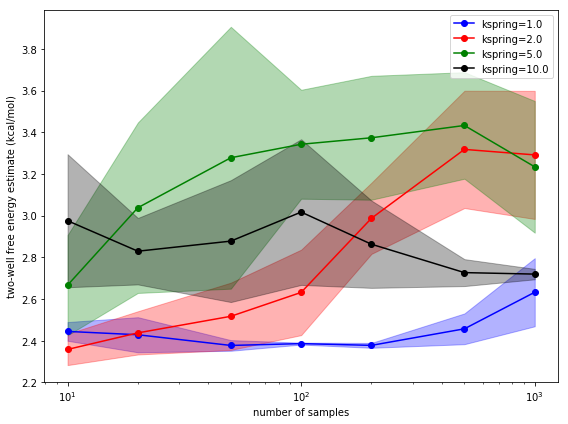

In [26]:

from matplotlib import pyplot as plt
%matplotlib inline

colors = ['b','r','g','k','m','y','c']

plt.figure( figsize=(8,6))
for j_kspring in range(len(kspring)):
    
    plt.plot(nsamples_tested, F_vs_nsamples_kspring[j_kspring,:], colors[j_kspring]+'o-', label='kspring=%3.1f'%kspring[j_kspring])
    plt.fill_between(nsamples_tested,
                     F_vs_nsamples_kspring[j_kspring,:] - dF_vs_nsamples_kspring[j_kspring,:],
                     F_vs_nsamples_kspring[j_kspring,:] + dF_vs_nsamples_kspring[j_kspring,:],
                     color=colors[j_kspring], alpha=0.3)
plt.legend(loc='best')
plt.xlabel('number of samples')
plt.ylabel('two-well free energy estimate (kcal/mol)')
plt.xscale('log')
plt.tight_layout()
plt.show()